## Contents

This notebook covers the basics of initializing and using the functionalities of simulator class. Various ways of simulating light curves that include 'power law distribution', 'user-defined responses', 'pre'defined responses' and 'impulse responses' are covered. The notebook also illustrates channel creation and ways to store and retrieve simulator objects.

## Setup

Import some useful libraries.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Import relevant stingray libraries.

In [2]:
from stingray import Lightcurve, Crossspectrum, sampledata
from stingray.simulator import simulator, models

# Creating a Simulator Object

Stingray has a simulator class which can be used to instantiate a simulator object and subsequently, perform simulations. Arguments can be passed in Simulator class to set the properties of simulated light curve. 

In this case, we instantiate a simulator object specifying the number of data points in the output light curve, the expected mean and binning interval.

In [3]:
sim = simulator.Simulator(N=1024, mean=0.5, dt=0.125)

We also import some sample data for later use.

In [5]:
sample = sampledata.sample_data().counts

# Light Curve Simulation

There are multiple way to simulate a light curve:

1. Using `power-law` spectrum
2. Using user-defined model
3. Using pre-defined models (`lorenzian` etc)
4. Using `impulse response`

## (i) Using power-law spectrum

By passing a `beta` value as a function argument, the shape of power-law spectrum can be defined. Passing `beta` as 1 gives a flicker-noise distribution.

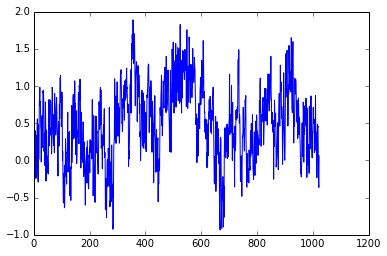

In [45]:
lc = sim.simulate(1)
plt.plot(lc.counts)

Passing `beta` as 2, gives random-walk distribution.

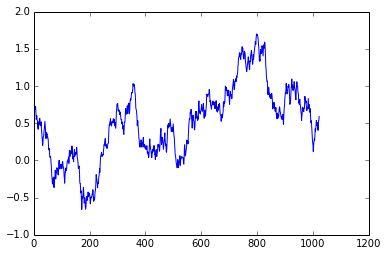

In [46]:
lc = sim.simulate(2)
plt.plot(lc.counts)

## (ii) Using user-defined model

Light curve can also be simulated using a user-defined spectrum.

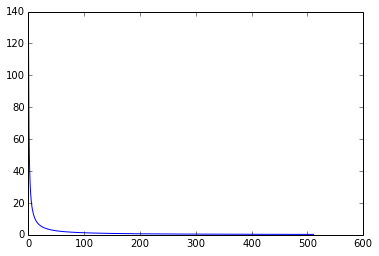

In [21]:
w = np.fft.rfftfreq(sim.N, d=sim.dt)[1:]
spectrum = np.power((1/w),2/2)
plt.plot(spectrum)

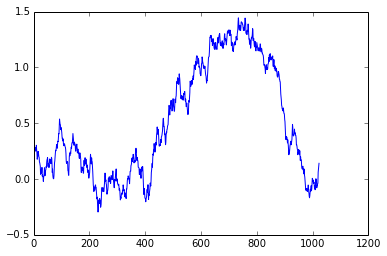

In [26]:
lc = sim.simulate(spectrum)
plt.plot(lc.counts)

## (iii) Using pre-defined models

One of the pre-defined spectrum models can also be used to simulate a light curve. In this case, model name and model parameters (as list iterable) need to be passed as function arguments.

To read more about the models and what the different parameters mean, see `models` notebook.

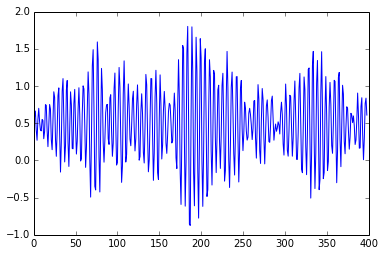

In [29]:
lc = sim.simulate('lorenzian', [1.5, .2, 1.2, 1.4])
plt.plot(lc.counts[1:400])

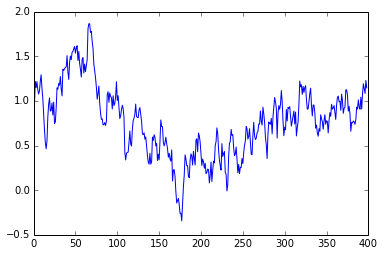

In [30]:
lc = sim.simulate('smoothbknpo', [.6, 0.9, .2, 4])
plt.plot(lc.counts[1:400])

## (iv) Using impulse response

Before simulating a light curve through this approach, an appropriate impulse response needs to be constructed. There
are two helper functions available for that purpose. 

`simple_ir()` allows to define an impulse response of constant height. It takes in starting time, width and intensity as arguments, all of whom are set by default.

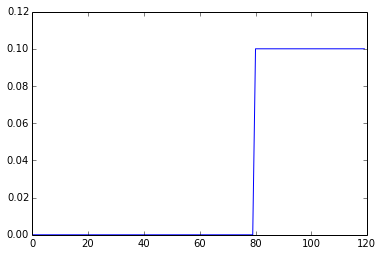

In [31]:
s_ir = sim.simple_ir(10, 5, 0.1)
plt.plot(s_ir)

A more realistic impulse response mimicking black hole dynamics can be created using `relativistic_ir()`. Its arguments are: primary peak time, secondary peak time, end time, primary peak value, secondary peak value, rise slope and decay slope. These paramaters are set to appropriate values by default.

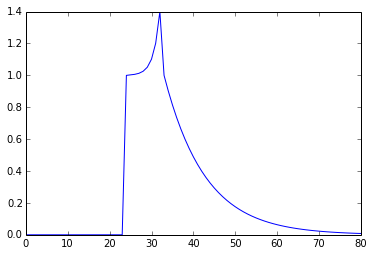

In [32]:
r_ir = sim.relativistic_ir()
r_ir = sim.relativistic_ir(t1=3, t2=4, t3=10, p1=1, p2=1.4, rise=0.6, decay=0.1)
plt.plot(r_ir)

Now, that the impulse response is ready, `simulate()` method can be called to produce a light curve.

In [33]:
lc_new = sim.simulate(sample, r_ir)

Since, the new light curve is produced by the convolution of original light curve and impulse response, its length is truncated by default for ease of analysis. This can be changed, however, by supplying an additional parameter `full`.

In [34]:
lc_new = sim.simulate(sample, r_ir, 'full')

Finally, some times, we do not need to include lag delay portion in the output light curve. This can be done by changing the final function parameter to `filtered`.

In [35]:
lc_new = sim.simulate(sample, r_ir, 'filtered')

To learn more about what the lags look like in practice, head to the `lag analysis` notebook.

# Channel Simulation

Here, we demonstrate simulator's functionality to simulate light curves independently for each channel. This is useful, for example, when dealing with energy dependent impulse responses where you can create a new channel for each energy range and simulate.

In practical situations, different channels may have different impulse responses and hence, would react differently to incoming light curves. To account for this, there is an option to simulate light curves and add them to corresponding energy channels.

In [43]:
sim.simulate_channel('3.5-4.5', 2)
sim.count_channels()

1

Above command assigns a `light curve` of random-walk distribution to energy channel of range 3.5-4.5. Notice, that `simulate_channel()` has the same parameters as `simulate()` with the exception of first parameter that describes the energy range of channel.

To get a `light curve` belonging to a specific channel, `get_channel()` is used.

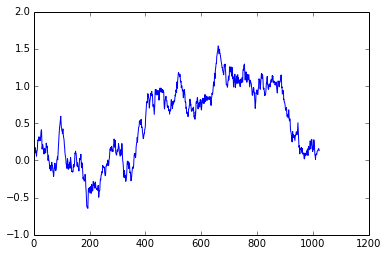

In [44]:
lc = sim.get_channel('3.5-4.5')
plt.plot(lc.counts)

A specific energy channel can also be deleted.

In [47]:
sim.delete_channel('3.5-4.5')
sim.count_channels()

0

Alternatively, if there are multiple channels that need to be added or deleted, this can be done by a single command.

In [49]:
sim.simulate_channel('3.5-4.5', 1)
sim.simulate_channel('4.5-5.5', 'smoothbknpo', [.6, 0.9, .2, 4])

In [50]:
sim.count_channels()

2

In [51]:
sim.get_channels(['3.5-4.5', '4.5-5.5'])
sim.delete_channels(['3.5-4.5', '4.5-5.5'])

In [52]:
sim.count_channels()

0

# Reading/Writing

Simulator object can be saved or retrieved at any time using `pickle`.

In [53]:
sim.write('data.pickle')

In [54]:
sim.read('data.pickle')